In [1]:
import os, glob

import matplotlib.pyplot as plt
import cv2

import lost_ds as lds

# Dataset paths
coco_path = 'lost_coco_annos.parquet'
shapes_path = 'lost_shape_annos.parquet'

# directory for visualization
vis_dir = '/tmp/lds_demo'

# Load the data


In [2]:
# pass a path-string (pandas style)
ds_coco = lds.LOSTDataset(coco_path)
# ds_shapes = lds.LOSTDataset(shapes_path)

# pass a list of path-strings (dask dataframe style)
ds = lds.LOSTDataset(coco_path)

# Feels like pandas
lost_ds is based on beloved pandas. 
Thats why we tried to get kind of a pandas feeling while using lost_ds. 
Some of those features are: 
- call functions on a LOSTDataset instance or on imported library
- use `inplace` argument as usual
- access to data by keys as usual


In [3]:
# First of all, you still can apply all your pandas knowledge easily by 
# accessing `ds.df` 
print(ds.df['img_path'].value_counts())

# And you can easily set it inplace
ds.df.reset_index(inplace=True)

# or like this 
ds.df = ds.df.reset_index()

000000123585.jpg    8
000000120777.jpg    4
000000121673.jpg    2
000000123213.jpg    2
000000125211.jpg    2
000000125257.jpg    2
Name: img_path, dtype: int64


In [4]:
# Oftenly it's the case that only a small amount of neat lds-function are 
# desired to be applied to a LOSTDataset. In order not to break a 
# pandas.DataFrame workflow lost_ds results and lost_ds arguments `df` are 
# always pandas.DataFrame instances. If you want to use chained functions you 
# could: 
    # 1. use the inplace argument
    # 2. assign the result DataFrame to an existing LOSTDataset instance
    # 3. create a new LOSTDataset instance from the DataFrame
# Where the first method propably is the most comfortable one.
    
# 1. call functions on LOSTDataset using inplace
ds_remap_1 = ds.copy()  # clone the LOSTDataset to prevent corrupting the original ds
ds_remap_1.remap_img_path(new_root_path='imgs', 
                          col='img_path', 
                          inplace=True)

# 2. assign a result dataframe to an existing instance
ds_remap_2 = ds.copy()
ds_remap_2.df = ds_remap_2.remap_img_path(col='img_path', 
                                          new_root_path='imgs')

# 3. create a new LOSTDataset instance 
ds_remap_3 = lds.LOSTDataset(lds.remap_img_path(ds.df, 
                                                new_root_path='imgs', 
                                                col='img_path'))


In [5]:
# Let's access data in our known pandas style
print(ds['img_path'].unique()[0])           # access with ds['key']
print(ds_remap_1['img_path'].unique()[0])
print(ds_remap_2['img_path'].unique()[0])
print(ds_remap_3['img_path'].unique()[0])

# of course we want to have the correct paths in our original LOSTDataset too
ds.remap_img_path('imgs', inplace=True)

000000120777.jpg
imgs/000000120777.jpg
imgs/000000120777.jpg
imgs/000000120777.jpg


In [6]:
# However, it's not possible to use `inplace` for every function since it not 
# always makes sense - e.g. in this case:  no argument `inplace` is provided
train, test, val = ds.split_by_img_path(0.2, 0.2)


# Visualization
Since data exploration is a very important step in machine learning lost_ds
provides visualization functions.

In [7]:
# The dataset contains one image that doesn't exist on our filesystem.
# This function checks if the files are present (and removes them `remove_invalid`).
ds.validate_image_paths(remove_invalid=True, inplace=True)

# You just could visualize the entire dataset to a specified directory
# The directory doesn't have to exist before
out_dir = os.path.join(vis_dir, 'vis_ds')
ds.vis_and_store(out_dir=out_dir)

visualize: 100%|██████████| 5/5 [00:00<00:00, 661.46it/s]


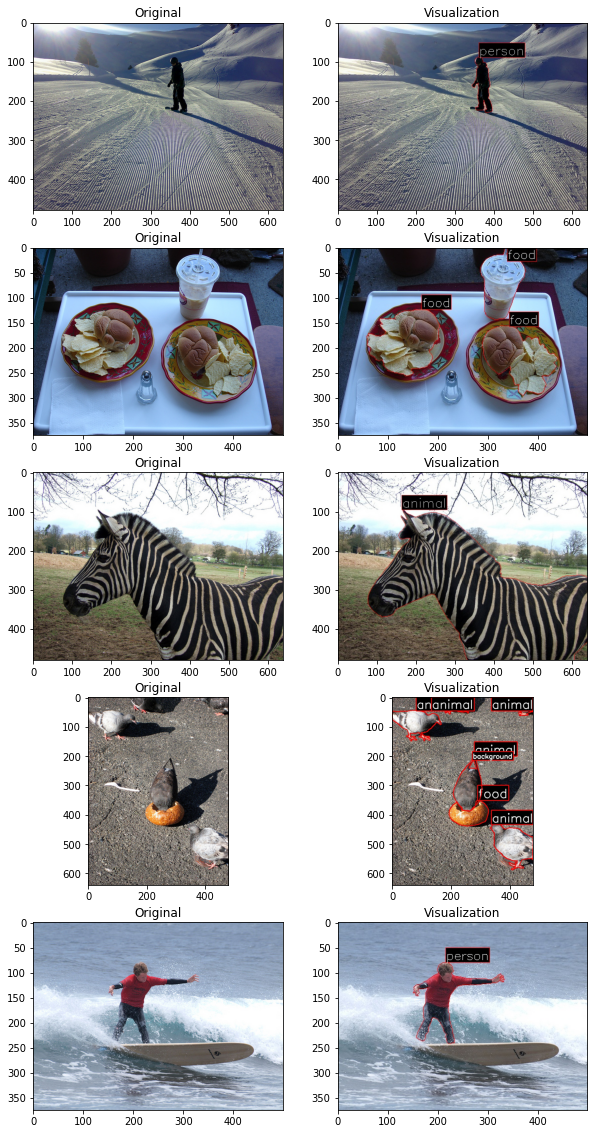

In [8]:

# let's explore visualized annos
def vis(out_dir, rows, png=False, org_dir=None):
    fig, axs = plt.subplots(rows, 2, figsize=(10, 20))
    img_paths = glob.glob(os.path.join(out_dir, '*.jpg')) + glob.glob(os.path.join(out_dir, '*.png'))
    for row, img_path in zip(range(rows), img_paths):
        axs[row][0].set_title('Original')
        if not org_dir:
            org_path = os.path.join('imgs', img_path.split('/')[-1])
        else:
            org_path = os.path.join(org_dir, img_path.split('/')[-1])
        if png:
            org_path = org_path.replace('.png', '.jpg')
        axs[row][0].imshow(cv2.cvtColor(cv2.imread(org_path), cv2.COLOR_BGR2RGB))
        
        axs[row][1].set_title('Visualization')
        vis_img = cv2.imread(img_path)
        if not png:
            vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
        axs[row][1].imshow(vis_img)
    
    plt.show()
    
vis(out_dir, len(ds['img_path'].unique()))

visualize: 100%|██████████| 5/5 [00:00<00:00, 3164.56it/s]


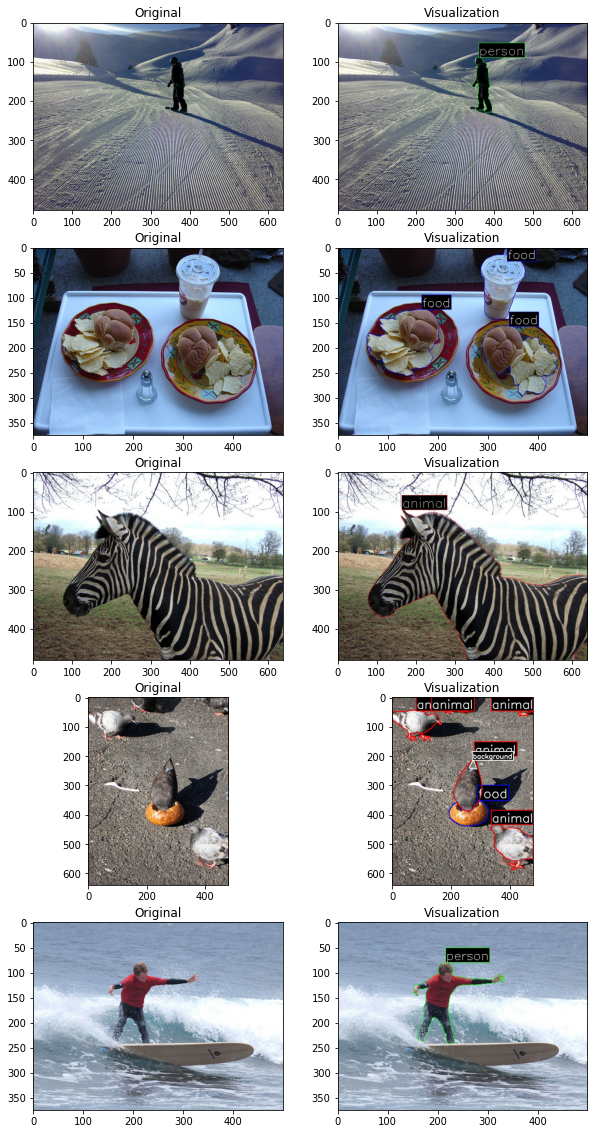

In [9]:
# `vis_and_store` has a couple of additional arguments to parametrize the 
# visualization. You can spicify the color by labels, the thickness by types 
# when passing a dictionary (or single values to visualize uniformly)
out_dir = os.path.join(vis_dir, 'vis_style')
ds.vis_and_store(out_dir, 
                 # It's BGR
                 color={'person': (0, 255, 0), 
                        'animal': (0, 0, 255), 
                        'food': (255, 0, 0)})
vis(out_dir, len(ds['img_path'].unique()))

# Functional
The LOSTDataset comes handy with a couple of functional operations. It is 
roughly grouped by the categories:
- Transformation
- Validation
- Splitting
- Filtering
- Semantic Segmentation
- Cropping

visualize: 100%|██████████| 5/5 [00:00<00:00, 3858.61it/s]


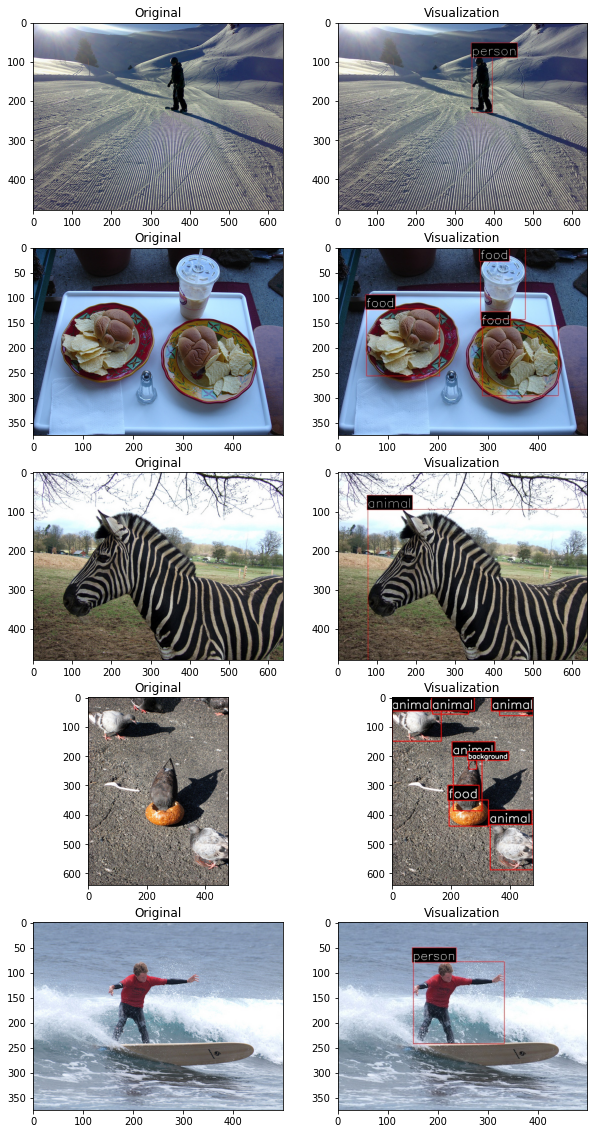

In [10]:
# transform anno-types. Currently we have no reasonable use case for anything
# besides `polygon_to_bbox` transformation
df_poly = ds[ds['anno_dtype']=='polygon']   # filter polygons in pandas-style
df_bbox = lds.polygon_to_bbox(df_poly)      # transform polygon-2-bbox
out_dir = os.path.join(vis_dir, 'vis_trans_bbox')   
lds.vis_and_store(df_bbox, out_dir)
vis(out_dir, len(ds['img_path'].unique()))                              # visualize

In [11]:
# transform anno-format (absolute, relative). If you want to use the data from 
# extern it's necessary like always, since the data always has a wrong format
keys = ['anno_format', 'anno_data']
print('Original format:\n', ds.df[keys].iloc[-1])
ds.to_abs(inplace=True)
print('\nAbsolute:\n', ds.df[keys].iloc[-1])
ds.to_rel(inplace=True)
print('\nAnd relative again:\n', ds.df[keys].iloc[-1])

to abs: 100%|██████████| 18/18 [00:00<00:00, 4076.54it/s]

Original format:
 anno_format                                                  rel
anno_data      [[0.5663703958317756, 0.18608311267289715], [0...
Name: 19, dtype: object



to rel: 100%|██████████| 18/18 [00:00<00:00, 6607.52it/s]


Absolute:
 anno_format                                                  abs
anno_data      [[362.47705333233637, 89.31989408299063], [366...
Name: 19, dtype: object

And relative again:
 anno_format                                                  rel
anno_data      [[0.5663703958317756, 0.18608311267289715], [0...
Name: 19, dtype: object


In [12]:
# Very often one has to transform the bbox-style since different ones are used 
# in machine learning (cv2, coco, lost, ...)
keys = ['anno_style', 'anno_data']
print('\ninitial style:\n', df_bbox[keys].iloc[0])
df_bbox_lost = lds.transform_bbox_style('xcycwh', df_bbox)
print('\nlost style:\n', df_bbox_lost[keys].iloc[0])
df_bbox_cv2 = lds.transform_bbox_style('xywh', df_bbox)
print('\ncv2 style:\n', df_bbox_cv2[keys].iloc[0])

# lds.vis_and_store(df_bbox_lost, os.path.join(vis_dir, 'vis_ds_lost_bbox'))
# lds.vis_and_store(df_bbox_cv2, os.path.join(vis_dir, 'vis_ds_cv2_bbox'))


initial style:
 anno_style                                             x1y1x2y2
anno_data     [0.11590449766355136, 0.32915887850467285, 0.4...
Name: 1, dtype: object

lost style:
 anno_style                                               xcycwh
anno_data     [0.26102599299065415, 0.5082990654205607, 0.29...
Name: 1, dtype: object

cv2 style:
 anno_style                                                 xywh
anno_data     [0.11590449766355136, 0.32915887850467285, 0.2...
Name: 1, dtype: object


In [13]:
# Some useful validations are:
# check basic geometry conditions (e.g. Polygon has to consist of at least 4 points)
dummy_df = ds.validate_geometries(remove_invalid=True)
# check if image files do exist
dummy_df = ds.validate_image_paths(remove_invalid=True)
# check if the dataset uses single labels and extraxt them to a new column 
# (multilabels always occur in a list which makes pandas filtering a nasty thing)
dummy_df = ds.validate_single_labels(lbl_col='anno_lbl', dst_col='single_lbl')
# check if annotations are unique by image and anno-data
dummy_df = ds.validate_unique_annos()
# remove empty entries IF non-empty entries do exist for the same image
dummy_df = ds.validate_empty_images()   

/home/dkoerner/development/code/lost_ds/lost_ds/functional/validation.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df.drop('data_hash', 'columns')


In [14]:
# Split your dataset
# get (validated) empty and non-empty entries
non_empty, empty = ds.split_by_empty()

# get a train/test/val-split by image path. You want to do that by image path
# since lost produces multiple rows for the same image, so .sample() or sklearn 
# train_test_split on the pandas dataframe won't work correctly
train, test, val = ds.split_by_img_path(0.2, 0.2)

# split multilabels into single-label columns. This makes pandas filtering by
# labels more comfortable for the user. The mapping should be by categories
# to resolve any multilabel cases. 
# The resulting single-labels columns you can easily filter by will be:
# 'anno_lbl_mammal'
# 'anno_lbl_shape'
# 'anno_lbl_food'
# 'anno_lbl_rest' 
mapping = {'mammal': ['person', 'animal'], 
           'shape': ['circle', 'square', 'line', 'others'], 
           'food': ['food'],
           'rest': ['background']}
ds_lbl = ds.split_multilabels(mapping, col='anno_lbl')
print(ds.keys())
print(ds_lbl.keys())

Index(['level_0', 'index', 'img_uid', 'img_timestamp', 'img_state',
       'img_sim_class', 'img_frame_n', 'img_path', 'img_iteration',
       'img_user_id', 'img_anno_time', 'img_lbl', 'img_user', 'img_is_junk',
       'img_fs_name', 'anno_uid', 'anno_timestamp', 'anno_state', 'anno_dtype',
       'anno_sim_class', 'anno_iteration', 'anno_user_id', 'anno_user',
       'anno_confidence', 'anno_anno_time', 'anno_lbl', 'anno_style',
       'anno_format', 'anno_data'],
      dtype='object')
Index(['level_0', 'index', 'img_uid', 'img_timestamp', 'img_state',
       'img_sim_class', 'img_frame_n', 'img_path', 'img_iteration',
       'img_user_id', 'img_anno_time', 'img_lbl', 'img_user', 'img_is_junk',
       'img_fs_name', 'anno_uid', 'anno_timestamp', 'anno_state', 'anno_dtype',
       'anno_sim_class', 'anno_iteration', 'anno_user_id', 'anno_user',
       'anno_confidence', 'anno_anno_time', 'anno_lbl', 'anno_style',
       'anno_format', 'anno_data', 'anno_lbl_mammal', 'anno_lbl_shape',


In [15]:
# Some often used filter operations are:

# remove empty entries of the dataframe 
ds.remove_empty()

# filter dataset by image path (keep or remove them inverse=True)
df_dummy = ds.img_selection(imgs=['path'], inverse=False)

# only keep entries where given labels occure (works with multi and single labels)
df_dummy = ds.label_selection(['background'], col='anno_lbl')

# remove entries where given labels occure (works with multi and single labels)
df_dummy = ds.ignore_labels(['background'], col='anno_lbl')

# get unique labels (works with multi and single labels)
u_labels = ds.unique_labels(col='anno_lbl')

# get a dataset mask by labels (works with multi and single labels)
p_mask = ds.selection_mask(['person'], col='anno_lbl')
df_person_only = ds.df[p_mask]

/home/dkoerner/development/code/lost_ds/lost_ds/segmentation/semantic_seg.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[seg_lbl_col] = df[lbl_col].apply(lambda x:
/home/dkoerner/development/code/lost_ds/lost_ds/segmentation/semantic_seg.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[seg_lbl_col] = df[seg_lbl_col].apply(lambda x:
segmentation: 100%|██████████| 5/5 [00:00<00:00, 3794.38it/s]


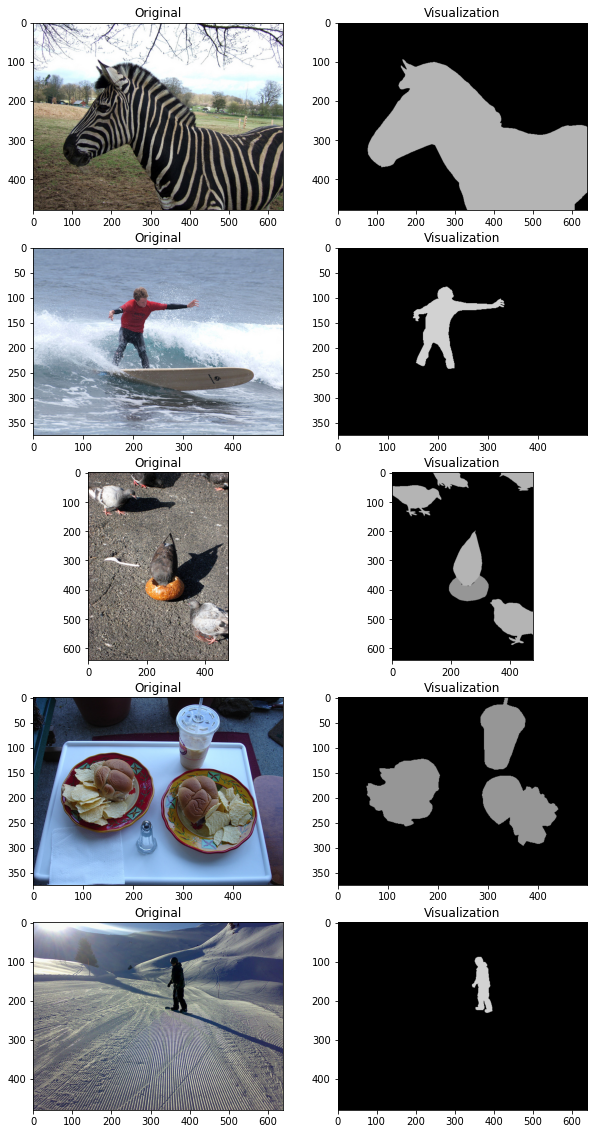

segmentation: 100%|██████████| 5/5 [00:00<00:00, 5658.80it/s]


In [16]:
# To train semantic segmentation cnn's its required to generate pixelmap's
# By providing a segmentation order the LOSTDataset can transform the annotations
# into semantic segmentations
# usually i would use values like 0,1,2,3.. but for visualization purposes i 
# directly use values with higher contrast 
order = {'background': 0,
         'circle': 30,
         'square': 60,
         'line': 90,
         'others': 120,
         'food': 150,
         'animal': 180,
         'person': 210}

# usually only polygons will be segmented
seg_dir = os.path.join(vis_dir, 'sem_seg')
seg_df = ds.semantic_segmentation(order=order, 
                                  dst_dir=seg_dir,
                                  fill_value=order['background'])
vis(seg_dir, len(ds['img_path'].unique()), png=True)

# but you can provide bbox too. You even could provide lines and points and 
# specify line_thickness and radius (simmilar to vis_and_store). But until now
# we had no real use-case for segmentations of lines and points.
seg_df = lds.semantic_segmentation(order=order, 
                                   dst_dir=os.path.join(vis_dir, 'sem_seg_bbox'),
                                   fill_value=order['background'],
                                   df=df_bbox,
                                   anno_dtypes=['bbox'],
                                   )

visualize: 100%|██████████| 26/26 [00:00<00:00, 5881.35it/s]


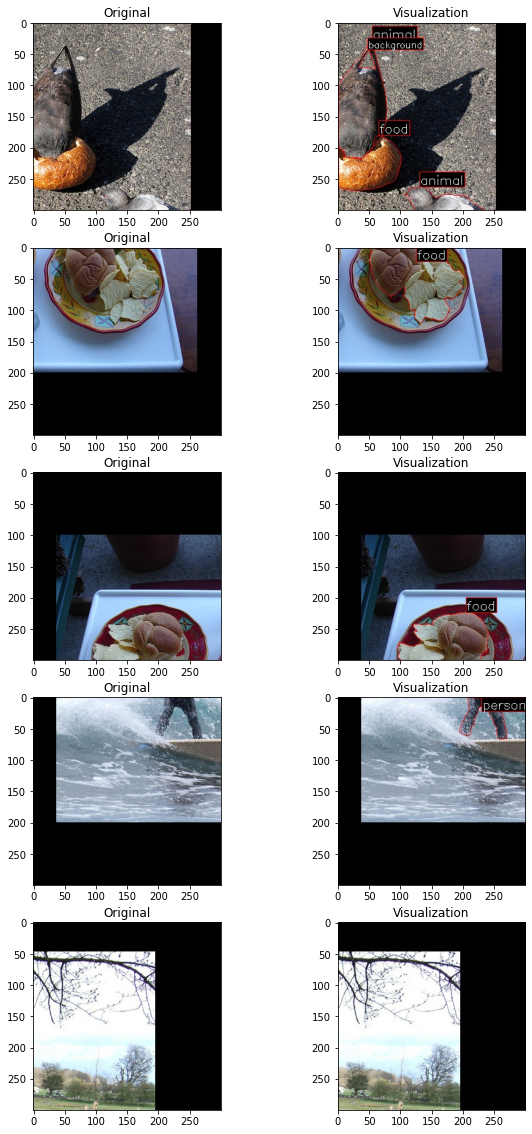

In [17]:

#### Crop
crop_df = ds.crop_dataset(os.path.join(vis_dir, 'crop_1k'),
                          crop_shape=(300, 300),
                          overlap=(25, 25),
                          write_emtpy=True,
                          fill_value=0)
lds.vis_and_store(crop_df, os.path.join(vis_dir, 'crop_vis'))
vis(os.path.join(vis_dir, 'crop_vis'), 5, org_dir=os.path.join(vis_dir, 'crop_1k'))


visualize: 100%|██████████| 8/8 [00:00<00:00, 4201.66it/s]


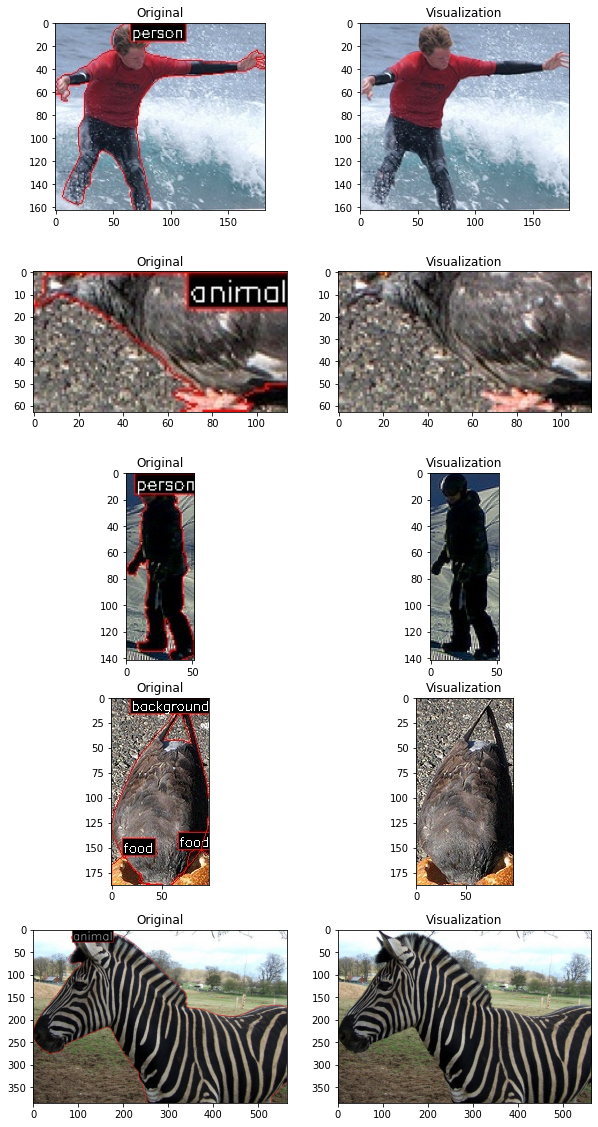

In [18]:
df_comp_crop = ds.crop_components(os.path.join(vis_dir, 'crop_mammals'),
                                 ['person', 'animal'], context=0)
lds.vis_and_store(df_comp_crop, os.path.join(vis_dir, 'comp_crop_vis'))
vis(os.path.join(vis_dir, 'crop_mammals'), 5, org_dir=os.path.join(vis_dir, 'comp_crop_vis'))